In [1]:
%config Completer.use_jedi = False #for auto complete code

In [2]:
from scipy.interpolate import griddata
from osgeo import osr
from osgeo import gdal
from osgeo import gdal_array
import rasterio
from rasterio.transform import from_origin
import geopandas as gpd

from shapely.geometry import mapping
from shapely.geometry import Polygon, Point, MultiLineString, MultiPoint
from collections import OrderedDict
import pandas as pd
import numpy as np

#plots
import matplotlib.pyplot as plt

#modflow
import flopy
import flopy.discretization as fgrid
import flopy.plot as fplot
from flopy.utils.gridintersect import GridIntersect
import flopy.utils.binaryfile as bf

import os, json

import mplleaflet

import sys
sys.path.insert(0, '../src')
from meshProperties import mesh_shape
from geoVoronoi import createVoronoi
#Create mesh object
vorMesh = createVoronoi()

#Define base refinement and refinement levels
vorMesh.defineParameters(maxRef = 80, minRef=20, stages=5)


/--------Sumary of cell discretization-------/
Maximun refinement: 80.00 m.
Minimum refinement: 20.00 m.
Cell size list: [80. 65. 50. 35. 20.] m.
/--------------------------------------------/



In [3]:
#Open limit layers and refinement definition layers
vorMesh.addLimit('basin','../examples/In/shp/Geospatial_model/ModelLimit1.shp')
vorMesh.addLayer('wells','../examples/In/shp/Geospatial_model/ModelWell2.shp')
vorMesh.addLayer('river','../examples/In/shp/Geospatial_model/ModelRiver2.shp')

In [4]:
#Generate point pair array
vorMesh.extractOrgVertices()

#Generate the point cloud and voronoi
vorMesh.createPointCloud()
vorMesh.generateVoronoi()

#check or create an output folder
outPath = '../examples/out/geospacial'
if os.path.isdir(outPath):
    print('The output folder %s exists'%outPath)
else:
    os.mkdir(outPath)
    print('The output folder %s has been generated.'%outPath)

#Export point data and voronoi polygons
#Points
vorMesh.getPointsAsShp('vertexOrg',outPath+'/vertexOrg.shp')
vorMesh.getPointsAsShp('vertexDist',outPath+'/vertexDist.shp')
vorMesh.getPointsAsShp('vertexBuffer',outPath+'/vertexBuffer.shp')
vorMesh.getPointsAsShp('vertexMaxRef',outPath+'/vertexMaxRef.shp')
vorMesh.getPointsAsShp('vertexMinRef',outPath+'/vertexMinRef.shp')
vorMesh.getPointsAsShp('vertexTotal',outPath+'/vertexTotal.shp')
#Polygons

vorMesh.getPolyAsShp('voronoiRegions',outPath+'/voronoiRegions.shp')


/----Sumary of points for voronoi meshing----/
Distributed points from layers: 342
Points from layer buffers: 955
Points from max refinement areas: 707
Points from min refinement areas: 330
Total points inside the limit: 2302
/--------------------------------------------/

Time required for point generation: 0.60 seconds 

The output folder ../examples/out/geospacial exists


# DISV

In [5]:
mesh=mesh_shape('../examples/out/geospacial/voronoiRegions.shp')
gridprops=mesh.get_gridprops_disv()

  0%|                                                                                         | 0/2302 [00:00<?, ?it/s]


Creating a unique list of vertices [[x1,y1],[x2,y2],...]

Extracting cell2d data and grid index


100%|████████████████████████████████████████████████████████████████████████████| 2302/2302 [00:00<00:00, 3844.98it/s]


In [6]:
cell2d = gridprops['cell2d']
vertices = gridprops['vertices']
ncpl = gridprops['ncpl']
nvert = gridprops['nvert']
centroids=gridprops['centroids']

# Geometria del Acuifero

In [7]:
#Extact dem values for each centroid of the voronois
src = rasterio.open('../examples/in/rst/ModeloDem1.tif')
elevation=[x for x in src.sample(centroids)]

nlay = 3

mtop=np.array([elev[0] for i,elev in enumerate(elevation)])

zbot=np.zeros((nlay,ncpl))

AcuifInf_Bottom = -120

AcuifMed_Bottom = AcuifInf_Bottom + (0.5 * (mtop - AcuifInf_Bottom))

AcuifSup_Bottom = AcuifInf_Bottom + (0.75 * (mtop - AcuifInf_Bottom))


zbot[0,] = AcuifSup_Bottom 
zbot[1,] = AcuifMed_Bottom
zbot[2,] = AcuifInf_Bottom


# Creación del modelo Modflow 6

In [8]:
# create simulation
model_name = 'geo_model'
model_ws = '../examples/out/geospacial/model'
exe_name = '../exe/mf6.exe'

sim = flopy.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=exe_name,sim_ws=model_ws)

In [9]:
# create tdis package

nper = 11
tdis_rc = [(1.0,1,1.0)] + [(200 * 86400.0, 4, 1.0) for a in range(nper -1)]

tdis=flopy.mf6.ModflowTdis(sim, nper=nper, time_units='seconds',perioddata=tdis_rc)

In [10]:
# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, linear_acceleration='BICGSTAB')

In [11]:
# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True, newtonoptions=['under_relaxation'])

In [12]:
# disv
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl,top=mtop, botm=zbot,nvert=nvert, vertices=vertices,cell2d=cell2d)

In [13]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=np.stack([mtop for i in range(nlay)]))

In [14]:
Kx =[1E-5,5E-4,2E-4]
icelltype = [1,1,0]
npf = flopy.mf6.ModflowGwfnpf(gwf,save_specific_discharge=True,icelltype=icelltype,k=Kx)

In [15]:
sto=flopy.mf6.ModflowGwfsto(gwf,ss=1e-05, sy=0.15)

In [16]:
evtr = 1.2/365/86400
evt = flopy.mf6.ModflowGwfevta(gwf,ievt=1,surface=mtop,rate=evtr,depth=1.0)

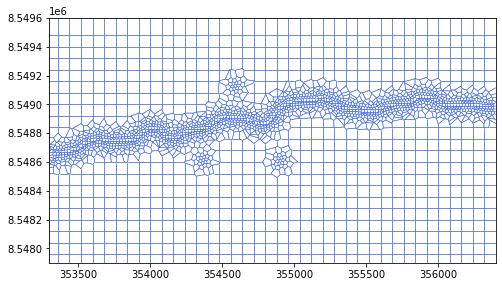

In [17]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.PlotMapView(model=gwf)
linecollection = modelmap.plot_grid(linewidth=0.5, color='royalblue')

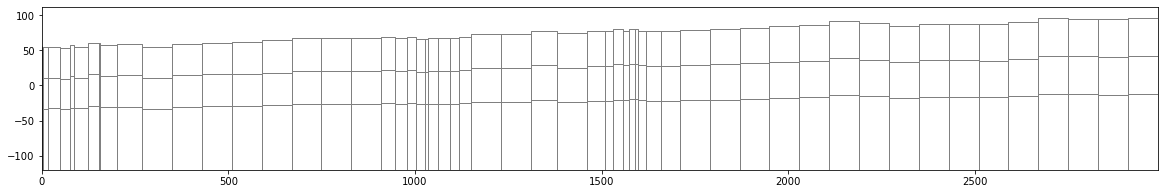

In [18]:
line = np.array([(353304.219,8548577.580), (356374.790,8548586.576)])

fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=gwf, line={"line": line})
linecollection = modelxsect.plot_grid()

## Para insertar las condiciones de recarga se realiza una interceptacion entre el shp de la zona de recarga y la grilla, de esta manera se optiene los indices de las celdas que conforman dicha zona

In [19]:
tgr = fgrid.VertexGrid(vertices, cell2d)
ix2 = GridIntersect(tgr)

C:\Users\jose\anaconda3\envs\work_env\lib\site-packages\flopy\utils\gridintersect.py:337: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = icell


In [20]:
zone1=gpd.read_file('../examples/In/shp/Geospatial_model/ModelRechargeZone1.shp')
result=ix2.intersect(zone1['geometry'].loc[0])

C:\Users\jose\anaconda3\envs\work_env\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
C:\Users\jose\anaconda3\envs\work_env\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


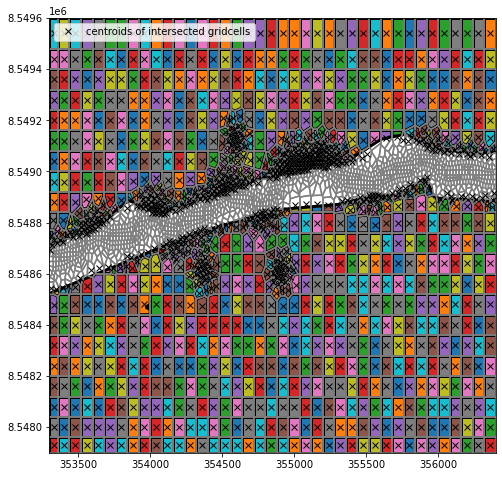

In [21]:
# install descartes 
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pmv = fplot.PlotMapView(ax=ax, modelgrid=tgr)
pmv.plot_grid()
ix2.plot_polygon(result, ax=ax, lw=3)

for cellid in result.cellids:
    (h2,) = ax.plot(
        tgr.xcellcenters[cellid],
        tgr.ycellcenters[cellid],
        "kx",
        label="centroids of intersected gridcells",
    )

ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

In [22]:
#stress_period_data : [cellid, elev, cond, aux, boundname]
rchr = 0.2/365/86400
rchr_list = []
for i in result.cellids:
    rchr_list.append([0,i,rchr])
rchr_spd = {0:rchr_list}

In [23]:
rch = flopy.mf6.ModflowGwfrch(gwf, stress_period_data=rchr_spd)

## Intersercción de pozos con la grilla

In [24]:
well_zone=gpd.read_file('../examples/In/shp/Geospatial_model/ModelWell2.shp')
list_wells=[]
for i in range(well_zone.shape[0]):
    
    list_wells.append(well_zone['geometry'].loc[i])
    
mp = MultiPoint(points=list_wells)

result=ix2.intersect(mp)

pump = -0.15
well_list = []
for i in result.cellids:
    well_list.append([1,i,pump])
well_spd = {1:well_list}

well=flopy.mf6.ModflowGwfwel(gwf,stress_period_data=well_spd)

In [25]:
#find out row order of intersenction cell inside the well shape
for cell in result.cellids:
    punto1= Point(centroids[cell])
    D=[]
    for index,row in well_zone.iterrows():
        D.append(punto1.distance(row['geometry']))

    print(D.index(min(D))) 

0
2
1


## Intersección del rio con la grilla

In [26]:
river_zone=gpd.read_file('../examples/In/shp/Geospatial_model/ModelRiver2.shp')

In [27]:
result=ix2.intersect(river_zone['geometry'].loc[0])

In [28]:
river_list = []
for i in result.cellids:
    river_list.append([0,i,mtop[i],0.01,mtop[i]-1])
river_spd = {0:river_list}

In [29]:
river=flopy.mf6.ModflowGwfriv(gwf,stress_period_data=river_spd)

## Condición regional de gradiente hidráulico

In [30]:
boundaries_zone=gpd.read_file('../examples/In/shp/Geospatial_model/ModelGHB1.shp')

In [31]:
boundaries_zone['GHB']=[55,55,90,90]
boundaries_zone

,id,geometry,GHB
0,1,"LINESTRING (353315.000 8549550.000, 353315.000...",55
1,2,"LINESTRING (353315.000 8548550.000, 353315.000...",55
2,3,"LINESTRING (356385.000 8549550.000, 356385.000...",90
3,4,"LINESTRING (356385.000 8548800.000, 356385.000...",90


In [32]:
"""
list_boundaries=[]
for i in range(boundaries_zone.shape[0]):
    
    list_boundaries.append(boundaries_zone['geometry'].loc[i])
    
mls = MultiLineString(lines=list_boundaries)
#intersec rivers with our grid
result=ix2.intersect(mls,sort_by_cellid=True)
"""

"\nlist_boundaries=[]\nfor i in range(boundaries_zone.shape[0]):\n    \n    list_boundaries.append(boundaries_zone['geometry'].loc[i])\n    \nmls = MultiLineString(lines=list_boundaries)\n#intersec rivers with our grid\nresult=ix2.intersect(mls,sort_by_cellid=True)\n"

In [33]:
ghb_list=[]
for index, row in boundaries_zone.iterrows():
    lines=row['geometry']
    partial = ix2.intersect(lines)
    for idx in partial.cellids:
        ghb_list.append([0,idx,row['GHB'],0.01])

In [34]:
#[cellid, bhead, cond, aux, boundname]
"""
ghb_list=[]

for idx in result.cellids:
    point=centroids[idx]
    if point[0]<354500:
         ghb_list.append([0,idx,55,0.01])
    else:
         ghb_list.append([0,idx,90,0.01])
"""
ghb_spd={0:ghb_list}

In [35]:
ghb=flopy.mf6.ModflowGwfghb(gwf,stress_period_data=ghb_spd)

In [36]:
hname = '{}.hds'.format(model_name)
cname = '{}.cbc'.format(model_name)
oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord=cname,
 head_filerecord=hname,
 saverecord=[('HEAD', 'ALL'), ('BUDGET',
'ALL')])

In [37]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model geo_model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package evta_0...
    writing package rch_0...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 1292 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 3 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 669 based on size of stress_period_data
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 37 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../exe/mf6.exe
                                   MODFL

(True, [])

# Plots

In [38]:
hds = bf.HeadFile(model_ws+'/'+model_name + '.hds')
head = hds.get_data()
head[head==1e+30]=np.nan
cpth = os.path.join(model_ws, model_name+'.cbc')
cobj = flopy.utils.CellBudgetFile(cpth, precision=hds.precision)
spd = cobj.get_data(text='DATA-SPDIS')[0]

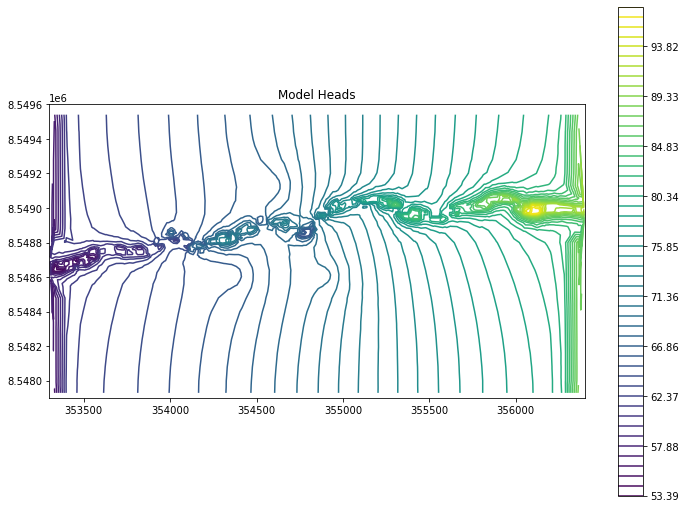

In [39]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=gwf)
#shp=flopy.plot.plot_shapefile('../examples/In/shp/Geospatial_model/ModelWell2.shp',ax=ax,radius=10)
#linecollection = mapview.plot_grid()

levels = np.linspace(np.nanmin(head),np.nanmax(head),num=50)
contour_set = mapview.contour_array(head,levels=levels)
t = ax.set_title("Model Heads")
plt.colorbar(contour_set, shrink=0.75)
plt.show()

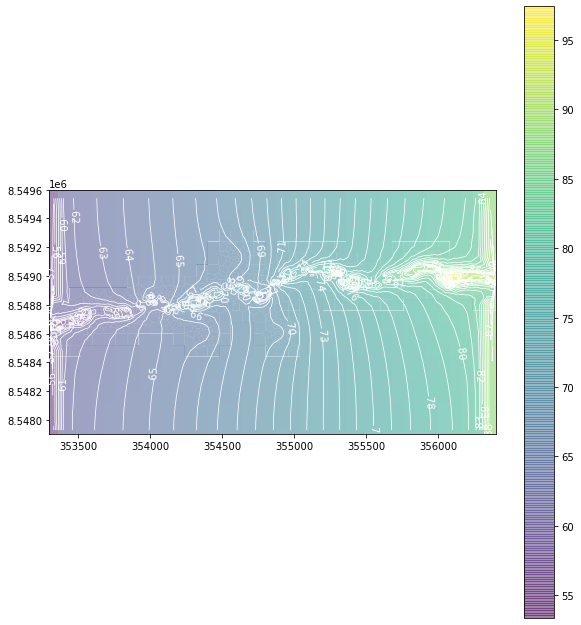

In [40]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=gwf)

quadmesh = mapview.plot_array(head, alpha=0.5)
levels = np.linspace(np.nanmin(head),np.nanmax(head),num=50)
c = mapview.contour_array(head, linewidths=0.75,colors='white',levels=levels)
plt.clabel(c, fmt='%3d')
#quiver = flopy.plot.plotutil.c(spd)
plt.colorbar(quadmesh, shrink=0.75)
plt.show()

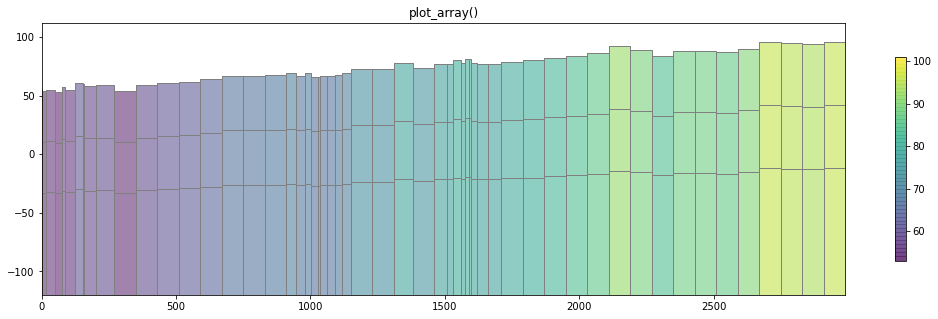

In [41]:
# get the head output for stress period 1 from the modflow6 head file
head = flopy.utils.HeadFile(os.path.join(model_ws, model_name+".hds"))
hdata = head.get_alldata()[0, :, :, :]

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("plot_array()")

xsect = flopy.plot.PlotCrossSection(model=gwf, line={"line": line})
patch_collection = xsect.plot_array(hdata, head=hdata, alpha=0.5)
line_collection = xsect.plot_grid()
cb = plt.colorbar(patch_collection, shrink=0.75)